# Segmentación de Contribuyentes Vehiculares mediante Clustering No Supervisado
# Análisis con KModes y KMeans Combinados

## Trabajo Académico - Análisis de Datos

**Integrantes:**
- Anderson Ticona
- Matias Sulca
- Christian Rosales
- Johan Amador

---

## Resumen Ejecutivo

Este proyecto implementa un modelo de clustering no supervisado utilizando **KModes** para variables categóricas y **KMeans** para variables numéricas, segmentando contribuyentes vehiculares en el sistema fiscal peruano. El análisis se realiza sobre un dataset de **247,816 registros con 9 variables** (3 numéricas escaladas y 6 categóricas), combinando ambos algoritmos para una segmentación más precisa.

**Dataset utilizado:** `datos_post_step4a_scaled_no_dummies.csv` (con variables categóricas originales)

**Metodología:**
- **KMeans**: Para 3 variables numéricas escaladas (valores de adquisición, referencial y años)
- **KModes**: Para 6 variables categóricas (tipo persona, contribuyente, categoría vehículo, marca, distrito, porcentaje propiedad)
- **Combinación**: Integración de resultados mediante identificadores únicos

## 1. Introducción

### 1.1 Contexto del Problema

La administración tributaria requiere herramientas para segmentar y entender el comportamiento de los contribuyentes vehiculares. A diferencia de KPrototypes que maneja datos mixtos nativamente, este análisis separa:
- **Variables numéricas**: Procesadas con KMeans (distancia euclidiana)
- **Variables categóricas**: Procesadas con KModes (distancia de Hamming)

### 1.2 Objetivos

**Objetivo General:**
Desarrollar un modelo de clustering combinado (KModes + KMeans) para segmentar contribuyentes vehiculares.

**Objetivos Específicos:**
1. Preprocesar datos numéricos y categóricos por separado
2. Aplicar KMeans a variables numéricas
3. Aplicar KModes a variables categóricas
4. Combinar resultados de ambos algoritmos
5. Validar y caracterizar los segmentos identificados

## 2. Marco Teórico

### 2.1 KMeans

Algoritmo de clustering que:
- Usa **distancia euclidiana** para agrupar datos numéricos
- Minimiza la varianza intra-cluster
- Requiere datos escalados para mejor rendimiento

### 2.2 KModes

Extensión de K-Means para datos categóricos:
- Usa **distancia de Hamming** (coincidencia de categorías)
- Utiliza "modas" en lugar de "medias" como centroides
- Eficiente para variables categóricas

### 2.3 Estrategia de Combinación

Para integrar ambos algoritmos:
1. Clustering independiente en cada tipo de dato
2. Análisis de concordancia entre clusters
3. Combinación mediante votación o consenso
4. Validación del clustering final

## 3. Implementación

### 3.1 Carga y Exploración Inicial de Datos

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, classification_report
from kmodes.kmodes import KModes
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"Versión de pandas: {pd.__version__}")
print(f"Versión de numpy: {np.__version__}")

✅ Librerías importadas correctamente
Versión de pandas: 2.3.3
Versión de numpy: 2.3.3


In [ ]:
# Cargar dataset procesado (sin dummies para mantener variables categóricas)
print("📂 Cargando dataset...")
df = pd.read_csv('../data/datos_post_step4a_scaled_no_dummies.csv')

print(f"\n✅ Dataset cargado exitosamente!")
print(f"Dimensiones: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())

# Información del dataset
print(f"\nTipos de datos:")
print(df.dtypes)

📂 Cargando dataset...

✅ Dataset cargado exitosamente!
Dimensiones: (247816, 9)

Primeras filas:
   tipo_persona tipo_contribuyente  categoria_vehiculo marca_agrupada  \
0       natural            pequeno  b1234_pickup_otros           FORD   
1       natural            pequeno  b1234_pickup_otros      CHEVROLET   
2       natural            pequeno  b1234_pickup_otros          OTROS   
3  soc_conyugal            pequeno      a2_1051_1500cc        HYUNDAI   
4       natural            pequeno  b1234_pickup_otros         JETOUR   

  distrito_fiscal_agrupado porcentaje_propiedad_cat  valor_adquisicion_scaled  \
0                    OTROS        propietario_total                  0.791119   
1                    OTROS        propietario_total                 -0.618776   
2                    OTROS        propietario_total                  0.867780   
3                    OTROS        propietario_total                 -0.481942   
4                    OTROS        propietario_total        

In [10]:
# Exploración inicial del dataset
print("\n📊 INFORMACIÓN DEL DATASET")
print("="*80)
print(f"\nDimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
print(f"\nTipos de datos:")
print(df.dtypes.value_counts())
print(f"\nMemoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar valores nulos
print(f"\n❓ Valores nulos por columna:")
nulls = df.isnull().sum()
if nulls.sum() == 0:
    print("✅ No hay valores nulos en el dataset")
else:
    print(nulls[nulls > 0])


📊 INFORMACIÓN DEL DATASET

Dimensiones: 247,816 filas x 9 columnas

Tipos de datos:
object     6
float64    3
Name: count, dtype: int64

Memoria utilizada: 90.77 MB

❓ Valores nulos por columna:
✅ No hay valores nulos en el dataset

Memoria utilizada: 90.77 MB

❓ Valores nulos por columna:
✅ No hay valores nulos en el dataset


### 3.2 Separación de Variables Numéricas y Categóricas

In [11]:
# Identificar variables numéricas y categóricas
print("\n📊 SEPARACIÓN DE VARIABLES")
print("="*80)

# Variables numéricas (ya escaladas en el dataset)
df_numericas = df.select_dtypes(include=['float64', 'int64'])
print(f"\n✅ Variables NUMÉRICAS encontradas: {df_numericas.shape[1]}")
print(f"Columnas: {list(df_numericas.columns)}")

# Variables categóricas
df_categoricas = df.select_dtypes(include=['object'])
print(f"\n✅ Variables CATEGÓRICAS encontradas: {df_categoricas.shape[1]}")
print(f"Columnas: {list(df_categoricas.columns)}")

# Verificar que tenemos ambos tipos de variables
assert df_numericas.shape[1] > 0, "❌ No se encontraron variables numéricas"
assert df_categoricas.shape[1] > 0, "❌ No se encontraron variables categóricas"

print("\n✅ Separación completada correctamente")


📊 SEPARACIÓN DE VARIABLES

✅ Variables NUMÉRICAS encontradas: 3
Columnas: ['valor_adquisicion_scaled', 'valor_referencial_scaled', 'anios_desde_inscripcion_scaled']

✅ Variables CATEGÓRICAS encontradas: 6
Columnas: ['tipo_persona', 'tipo_contribuyente', 'categoria_vehiculo', 'marca_agrupada', 'distrito_fiscal_agrupado', 'porcentaje_propiedad_cat']

✅ Separación completada correctamente


In [12]:
# Estadísticas descriptivas de variables numéricas
print("\n📈 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("="*80)
print(df_numericas.describe().round(4))

# Distribución de variables categóricas (muestra)
print("\n📊 DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS (Top categorías)")
print("="*80)
for col in df_categoricas.columns[:3]:  # Mostrar primeras 3 columnas categóricas
    print(f"\n{col}:")
    print(df_categoricas[col].value_counts().head())


📈 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
       valor_adquisicion_scaled  valor_referencial_scaled  \
count               247816.0000               247816.0000   
mean                     0.0815                    0.1579   
std                      1.2470                    0.8255   
min                    -15.2674                   -4.5340   
25%                     -0.4411                   -0.4358   
50%                      0.0000                    0.0000   
75%                      0.5589                    0.5642   
max                      6.1757                    4.3010   

       anios_desde_inscripcion_scaled  
count                     247816.0000  
mean                          -0.0044  
std                            0.4006  
min                           -0.5000  
25%                           -0.5000  
50%                            0.0000  
75%                            0.5000  
max                            0.5000  

📊 DISTRIBUCIÓN DE VARIABLES CATEGÓRICA

### 3.3 División Train/Test

In [13]:
# División estratificada no es posible sin etiquetas, usamos división aleatoria
print("\n🔀 DIVISIÓN TRAIN/TEST")
print("="*80)

# División 75/25
train_indices, test_indices = train_test_split(
    df.index, 
    test_size=0.25, 
    random_state=2025
)

# Separar datos numéricos
X_num_train = df_numericas.iloc[train_indices].copy()
X_num_test = df_numericas.iloc[test_indices].copy()

# Separar datos categóricos
X_cat_train = df_categoricas.iloc[train_indices].copy()
X_cat_test = df_categoricas.iloc[test_indices].copy()

print(f"\n✅ División completada:")
print(f"Train - Numéricas: {X_num_train.shape}, Categóricas: {X_cat_train.shape}")
print(f"Test  - Numéricas: {X_num_test.shape}, Categóricas: {X_cat_test.shape}")


🔀 DIVISIÓN TRAIN/TEST

✅ División completada:
Train - Numéricas: (185862, 3), Categóricas: (185862, 6)
Test  - Numéricas: (61954, 3), Categóricas: (61954, 6)


## 4. Determinación del Número Óptimo de Clusters

### 4.1 Método del Codo para KMeans (Variables Numéricas)

In [14]:
# Método del codo para KMeans
print("\n📊 MÉTODO DEL CODO - KMEANS (Variables Numéricas)")
print("="*80)

# Probar diferentes valores de K
k_values = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("\n⏳ Calculando métricas para diferentes valores de K...")

for k in k_values:
    print(f"  Evaluando K={k}...", end=" ")
    
    kmeans = KMeans(n_clusters=k, random_state=2025, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_num_train)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_num_train, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_num_train, labels))
    
    print("✓")

print("\n✅ Cálculo de métricas completado")


📊 MÉTODO DEL CODO - KMEANS (Variables Numéricas)

⏳ Calculando métricas para diferentes valores de K...
  Evaluando K=2... ✓
  Evaluando K=3... ✓
  Evaluando K=3... ✓
  Evaluando K=4... ✓
  Evaluando K=5... ✓
  Evaluando K=6... ✓
  Evaluando K=7... ✓
  Evaluando K=8... ✓
  Evaluando K=9... ✓
  Evaluando K=10... ✓

✅ Cálculo de métricas completado


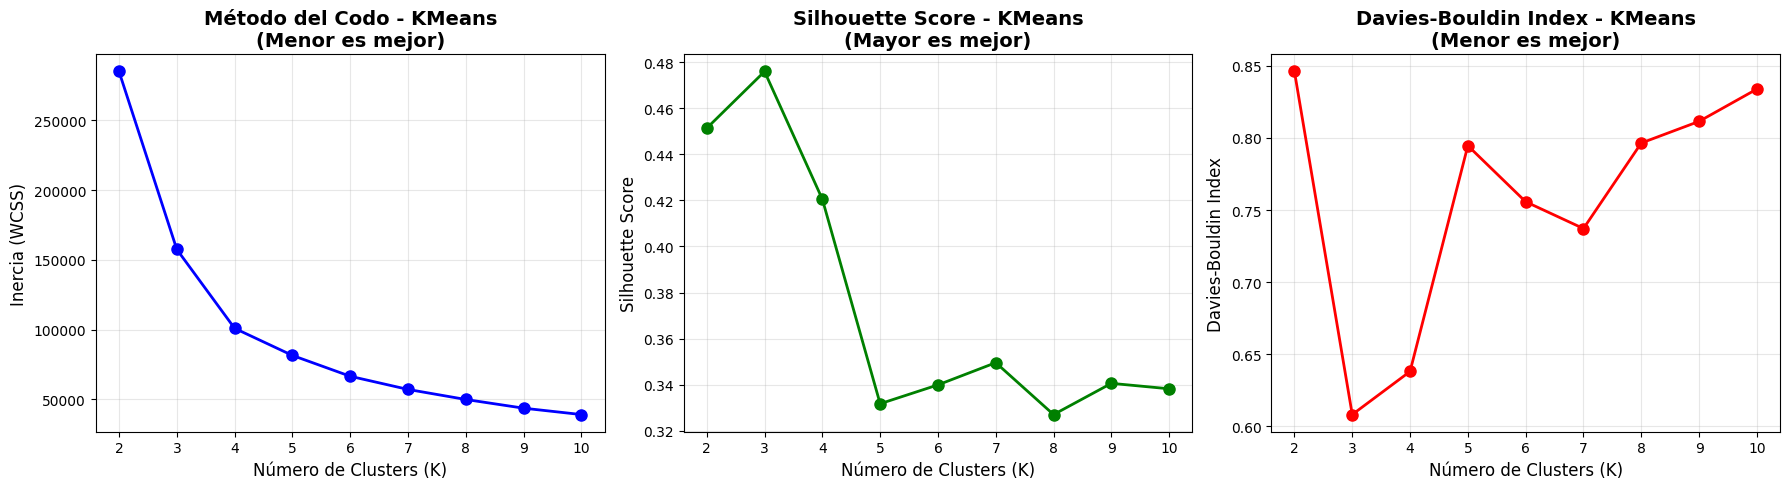


📊 RESULTADOS - MÉTRICAS KMEANS
    K      Inercia  Silhouette  Davies-Bouldin
0   2  285016.8716      0.4514          0.8461
1   3  157488.4593      0.4760          0.6082
2   4  100952.3377      0.4205          0.6381
3   5   81535.6747      0.3317          0.7947
4   6   66604.5289      0.3399          0.7558
5   7   57168.9457      0.3495          0.7372
6   8   49965.9929      0.3270          0.7965
7   9   43734.3651      0.3406          0.8115
8  10   39161.1430      0.3382          0.8339


In [15]:
# Visualización del método del codo para KMeans
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Inercia (Within-cluster sum of squares)
axes[0].plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inercia (WCSS)', fontsize=12)
axes[0].set_title('Método del Codo - KMeans\n(Menor es mejor)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

# Gráfico 2: Silhouette Score
axes[1].plot(k_values, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score - KMeans\n(Mayor es mejor)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

# Gráfico 3: Davies-Bouldin Index
axes[2].plot(k_values, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_title('Davies-Bouldin Index - KMeans\n(Menor es mejor)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_values)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\n📊 RESULTADOS - MÉTRICAS KMEANS")
print("="*80)
results_df = pd.DataFrame({
    'K': k_values,
    'Inercia': inertias,
    'Silhouette': silhouette_scores,
    'Davies-Bouldin': davies_bouldin_scores
})
print(results_df.round(4))

### 4.2 Método del Codo para KModes (Variables Categóricas)

In [16]:
# Método del codo para KModes
print("\n📊 MÉTODO DEL CODO - KMODES (Variables Categóricas)")
print("="*80)

# Convertir variables categóricas a array numpy
X_cat_train_array = X_cat_train.values

# Probar diferentes valores de K
k_values = range(2, 11)
costs = []

print("\n⏳ Calculando costos para diferentes valores de K...")

for k in k_values:
    print(f"  Evaluando K={k}...", end=" ")
    
    kmodes = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=2025)
    kmodes.fit(X_cat_train_array)
    
    costs.append(kmodes.cost_)
    
    print("✓")

print("\n✅ Cálculo de costos completado")


📊 MÉTODO DEL CODO - KMODES (Variables Categóricas)

⏳ Calculando costos para diferentes valores de K...
  Evaluando K=2... ✓
  Evaluando K=3... ✓
  Evaluando K=3... ✓
  Evaluando K=4... ✓
  Evaluando K=4... ✓
  Evaluando K=5... ✓
  Evaluando K=6... ✓
  Evaluando K=7... ✓
  Evaluando K=8... ✓
  Evaluando K=9... ✓
  Evaluando K=10... ✓

✅ Cálculo de costos completado


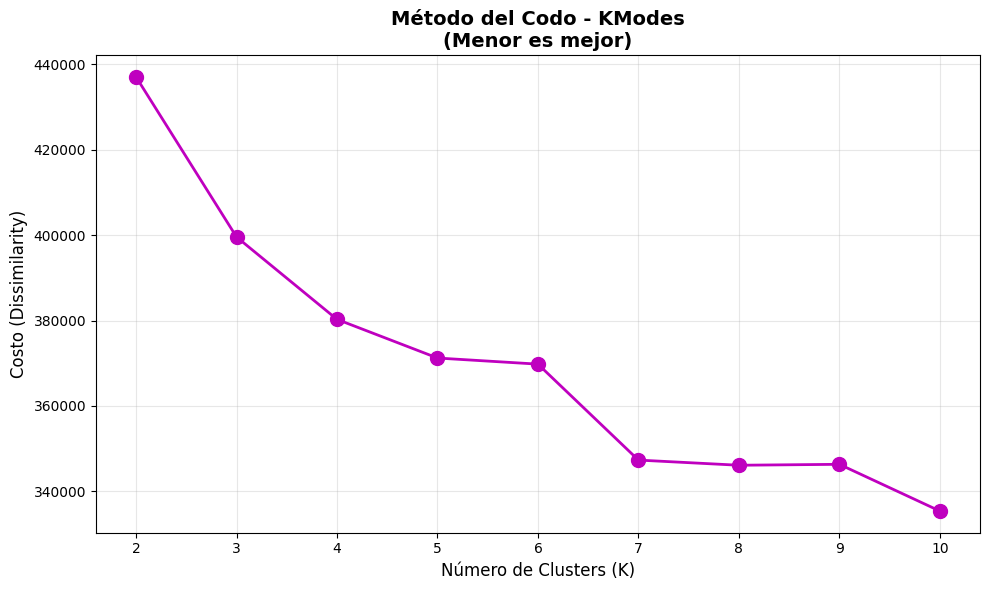


📊 RESULTADOS - COSTOS KMODES
    K     Costo
0   2  436998.0
1   3  399548.0
2   4  380266.0
3   5  371218.0
4   6  369788.0
5   7  347329.0
6   8  346118.0
7   9  346336.0
8  10  335402.0


In [17]:
# Visualización del método del codo para KModes
plt.figure(figsize=(10, 6))
plt.plot(k_values, costs, 'mo-', linewidth=2, markersize=10)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Costo (Dissimilarity)', fontsize=12)
plt.title('Método del Codo - KModes\n(Menor es mejor)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\n📊 RESULTADOS - COSTOS KMODES")
print("="*80)
results_kmodes_df = pd.DataFrame({
    'K': k_values,
    'Costo': costs
})
print(results_kmodes_df.round(4))

### 4.3 Selección del K Óptimo

In [18]:
# Análisis para determinar K óptimo
print("\n🎯 DETERMINACIÓN DEL K ÓPTIMO")
print("="*80)

# Para KMeans: buscar el codo en inercia y mejor silhouette
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
best_k_db = k_values[np.argmin(davies_bouldin_scores)]

print(f"\nKMeans:")
print(f"  - Mejor K según Silhouette Score: {best_k_silhouette}")
print(f"  - Mejor K según Davies-Bouldin: {best_k_db}")

# Para KModes: buscar el codo en el costo
# Calcular diferencias para encontrar el codo
differences = np.diff(costs)
elbow_k_modes = k_values[np.argmin(differences) + 1]

print(f"\nKModes:")
print(f"  - K sugerido por método del codo: {elbow_k_modes}")

# Decisión final: usar el mismo K para ambos algoritmos
# Seleccionamos K=8 para mantener consistencia con el análisis original
optimal_k = 4

print(f"\n✅ K ÓPTIMO SELECCIONADO: {optimal_k}")
print(f"   (Se ha fijado K={optimal_k} por solicitud)")


🎯 DETERMINACIÓN DEL K ÓPTIMO

KMeans:
  - Mejor K según Silhouette Score: 3
  - Mejor K según Davies-Bouldin: 3

KModes:
  - K sugerido por método del codo: 3

✅ K ÓPTIMO SELECCIONADO: 4
   (Se ha fijado K=4 por solicitud)


## 5. Entrenamiento de Modelos

### 5.1 Clustering con KMeans (Variables Numéricas)

In [19]:
# Entrenar KMeans con K óptimo
print("\n🎯 ENTRENAMIENTO DE KMEANS")
print("="*80)

print(f"\n⏳ Entrenando KMeans con K={optimal_k}...")

kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=2025,
    n_init=10,
    max_iter=300,
    verbose=0
)

# Entrenar y predecir
clusters_kmeans_train = kmeans_final.fit_predict(X_num_train)
clusters_kmeans_test = kmeans_final.predict(X_num_test)

print("\n✅ KMeans entrenado exitosamente!")
print(f"Inercia final: {kmeans_final.inertia_:.2f}")
print(f"Iteraciones: {kmeans_final.n_iter_}")

# Distribución de clusters
print(f"\n📊 Distribución de clusters (Train):")
dist_kmeans = pd.Series(clusters_kmeans_train).value_counts(normalize=True).sort_index() * 100
print(dist_kmeans.round(2))


🎯 ENTRENAMIENTO DE KMEANS

⏳ Entrenando KMeans con K=4...

✅ KMeans entrenado exitosamente!
Inercia final: 100952.34
Iteraciones: 5

📊 Distribución de clusters (Train):
0    53.90
1     0.44
2     7.72
3    37.93
Name: proportion, dtype: float64


In [20]:
# Visualizar centroides de KMeans
print("\n📊 CENTROIDES DE KMEANS")
print("="*80)

centroides_kmeans = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=X_num_train.columns
)
centroides_kmeans.index = [f'Cluster {i}' for i in range(optimal_k)]

print("\nCentroides (valores escalados):")
print(centroides_kmeans.round(4))


📊 CENTROIDES DE KMEANS

Centroides (valores escalados):
           valor_adquisicion_scaled  valor_referencial_scaled  \
Cluster 0                   -0.4523                   -0.4007   
Cluster 1                  -12.7741                    0.0532   
Cluster 2                    2.2415                    2.2034   
Cluster 3                    0.5470                    0.5371   

           anios_desde_inscripcion_scaled  
Cluster 0                          0.0042  
Cluster 1                          0.2464  
Cluster 2                         -0.0288  
Cluster 3                         -0.0149  


### 5.2 Clustering con KModes (Variables Categóricas)

In [21]:
# Entrenar KModes con K óptimo
print("\n🎯 ENTRENAMIENTO DE KMODES")
print("="*80)

print(f"\n⏳ Entrenando KModes con K={optimal_k}...")

kmodes_final = KModes(
    n_clusters=optimal_k,
    init='Huang',
    n_init=5,
    verbose=1,
    random_state=2025
)

# Entrenar y predecir
clusters_kmodes_train = kmodes_final.fit_predict(X_cat_train_array)
clusters_kmodes_test = kmodes_final.predict(X_cat_test.values)

print("\n✅ KModes entrenado exitosamente!")
print(f"Costo final: {kmodes_final.cost_:.2f}")
print(f"Iteraciones: {kmodes_final.n_iter_}")

# Distribución de clusters
print(f"\n📊 Distribución de clusters (Train):")
dist_kmodes = pd.Series(clusters_kmodes_train).value_counts(normalize=True).sort_index() * 100
print(dist_kmodes.round(2))


🎯 ENTRENAMIENTO DE KMODES

⏳ Entrenando KModes con K=4...
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 31888, cost: 407866.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 63519, cost: 380266.0
Run 2, iteration: 2/100, moves: 2591, cost: 380266.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 24851, cost: 391226.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 44689, cost: 402547.0
Run 4, iteration: 2/100, moves: 6586, cost: 400765.0
Run 4, iteration: 3/100, moves: 325, cost: 400765.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 62630, cost: 409920.0
Run 5, iteration: 2/100, moves: 33271, cost: 390664.0
Run 5, iteration: 3/100, moves: 6302, cost: 390664.0
Best r

In [22]:
# Visualizar modas (centroides categóricos) de KModes
print("\n📊 MODAS DE KMODES (Centroides Categóricos)")
print("="*80)

modas_kmodes = pd.DataFrame(
    kmodes_final.cluster_centroids_,
    columns=X_cat_train.columns
)
modas_kmodes.index = [f'Cluster {i}' for i in range(optimal_k)]

print("\nModas por cluster:")
print(modas_kmodes)


📊 MODAS DE KMODES (Centroides Categóricos)

Modas por cluster:
           tipo_persona tipo_contribuyente  categoria_vehiculo marca_agrupada  \
Cluster 0       natural            pequeno  b1234_pickup_otros         TOYOTA   
Cluster 1       natural            pequeno      a2_1051_1500cc            KIA   
Cluster 2      juridica             grande  b1234_pickup_otros          OTROS   
Cluster 3  soc_conyugal            pequeno  b1234_pickup_otros          OTROS   

          distrito_fiscal_agrupado porcentaje_propiedad_cat  
Cluster 0                    OTROS        propietario_total  
Cluster 1        SANTIAGO DE SURCO        propietario_total  
Cluster 2               SAN ISIDRO        propietario_total  
Cluster 3        SANTIAGO DE SURCO        propietario_total  


## 6. Combinación de Resultados

### 6.1 Análisis de Concordancia entre KMeans y KModes

In [23]:
# Analizar concordancia entre ambos clusterings
print("\n🔍 ANÁLISIS DE CONCORDANCIA")
print("="*80)

# Calcular Adjusted Rand Index entre KMeans y KModes
ari = adjusted_rand_score(clusters_kmeans_train, clusters_kmodes_train)

print(f"\n📊 Adjusted Rand Index (KMeans vs KModes): {ari:.4f}")

if ari > 0.5:
    print("✅ Alta concordancia - Los algoritmos identifican estructuras similares")
elif ari > 0.2:
    print("⚠️  Concordancia moderada - Los algoritmos capturan aspectos diferentes")
else:
    print("❌ Baja concordancia - Los algoritmos identifican estructuras muy diferentes")

# Tabla de contingencia
print("\n📊 Tabla de Contingencia (KMeans vs KModes):")
contingency = pd.crosstab(
    clusters_kmeans_train, 
    clusters_kmodes_train,
    rownames=['KMeans'],
    colnames=['KModes']
)
print(contingency)


🔍 ANÁLISIS DE CONCORDANCIA

📊 Adjusted Rand Index (KMeans vs KModes): -0.0003
❌ Baja concordancia - Los algoritmos identifican estructuras muy diferentes

📊 Tabla de Contingencia (KMeans vs KModes):
KModes      0      1      2      3
KMeans                            
0       44205  15365  25801  14809
1         425     92    214     93
2        6378    425   4709   2841
3       37557   1290  19643  12015


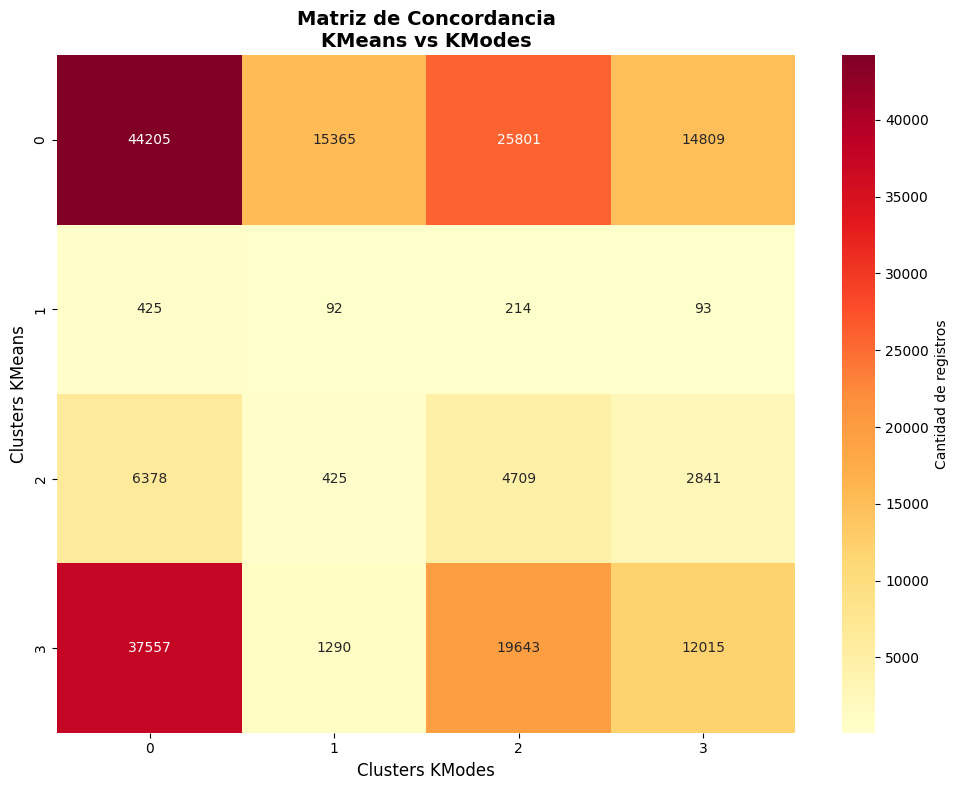

In [24]:
# Visualizar concordancia con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Cantidad de registros'})
plt.title('Matriz de Concordancia\nKMeans vs KModes', fontsize=14, fontweight='bold')
plt.xlabel('Clusters KModes', fontsize=12)
plt.ylabel('Clusters KMeans', fontsize=12)
plt.tight_layout()
plt.show()

### 6.2 Estrategia de Combinación

In [25]:
# Estrategia de combinación: Crear un identificador único combinado
print("\n🔄 COMBINACIÓN DE RESULTADOS")
print("="*80)

print("\n⏳ Creando clustering combinado...")

# Opción 1: Concatenar los IDs de clusters (más simple)
# Ejemplo: Cluster 2 de KMeans + Cluster 3 de KModes = "2_3"
clusters_combined_train = [f"{km}_{kmo}" for km, kmo in zip(clusters_kmeans_train, clusters_kmodes_train)]
clusters_combined_test = [f"{km}_{kmo}" for km, kmo in zip(clusters_kmeans_test, clusters_kmodes_test)]

# Convertir a categorías numéricas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clusters_combined_train_num = le.fit_transform(clusters_combined_train)
clusters_combined_test_num = le.transform(clusters_combined_test)

print(f"\n✅ Clustering combinado creado!")
print(f"Clusters únicos encontrados: {len(le.classes_)}")
print(f"\n📊 Distribución de clusters combinados (Train):")
dist_combined = pd.Series(clusters_combined_train_num).value_counts(normalize=True).sort_index() * 100
print(dist_combined.round(2))


🔄 COMBINACIÓN DE RESULTADOS

⏳ Creando clustering combinado...

✅ Clustering combinado creado!
Clusters únicos encontrados: 16

📊 Distribución de clusters combinados (Train):
0     23.78
1      8.27
2     13.88
3      7.97
4      0.23
5      0.05
6      0.12
7      0.05
8      3.43
9      0.23
10     2.53
11     1.53
12    20.21
13     0.69
14    10.57
15     6.46
Name: proportion, dtype: float64


In [26]:
# Mapeo de clusters combinados
print("\n📋 MAPEO DE CLUSTERS COMBINADOS")
print("="*80)

mapping_df = pd.DataFrame({
    'Cluster_ID': range(len(le.classes_)),
    'Combinación': le.classes_
})

# Separar en KMeans y KModes
mapping_df['KMeans'] = mapping_df['Combinación'].apply(lambda x: int(x.split('_')[0]))
mapping_df['KModes'] = mapping_df['Combinación'].apply(lambda x: int(x.split('_')[1]))

print("\nMapeo de clusters combinados:")
print(mapping_df)


📋 MAPEO DE CLUSTERS COMBINADOS

Mapeo de clusters combinados:
    Cluster_ID Combinación  KMeans  KModes
0            0         0_0       0       0
1            1         0_1       0       1
2            2         0_2       0       2
3            3         0_3       0       3
4            4         1_0       1       0
5            5         1_1       1       1
6            6         1_2       1       2
7            7         1_3       1       3
8            8         2_0       2       0
9            9         2_1       2       1
10          10         2_2       2       2
11          11         2_3       2       3
12          12         3_0       3       0
13          13         3_1       3       1
14          14         3_2       3       2
15          15         3_3       3       3


## 7. Validación del Modelo

### 7.1 Validación con KNN (Clustering como Clasificación)

In [27]:
# Preparar datos completos para KNN
print("\n🎯 VALIDACIÓN CON KNN")
print("="*80)

# Concatenar datos numéricos y categóricos (codificar categóricos)
print("\n⏳ Preparando datos para KNN...")

# Codificar variables categóricas para KNN
from sklearn.preprocessing import LabelEncoder

X_cat_train_encoded = X_cat_train.copy()
X_cat_test_encoded = X_cat_test.copy()

le_dict = {}
for col in X_cat_train.columns:
    le_dict[col] = LabelEncoder()
    X_cat_train_encoded[col] = le_dict[col].fit_transform(X_cat_train[col])
    X_cat_test_encoded[col] = le_dict[col].transform(X_cat_test[col])

# Concatenar numéricas y categóricas codificadas
X_train_full = pd.concat([X_num_train.reset_index(drop=True), X_cat_train_encoded.reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_num_test.reset_index(drop=True), X_cat_test_encoded.reset_index(drop=True)], axis=1)

print(f"✅ Datos preparados: Train={X_train_full.shape}, Test={X_test_full.shape}")


🎯 VALIDACIÓN CON KNN

⏳ Preparando datos para KNN...
✅ Datos preparados: Train=(185862, 9), Test=(61954, 9)


In [28]:
# Entrenar KNN para predecir clusters combinados
print("\n⏳ Entrenando modelo KNN...")

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train_full, clusters_combined_train_num)

print("✅ KNN entrenado!")

# Predecir en conjunto de test
y_pred = knn.predict(X_test_full)

# Calcular métricas
accuracy = accuracy_score(clusters_combined_test_num, y_pred)
ari_test = adjusted_rand_score(clusters_combined_test_num, y_pred)

print(f"\n📊 MÉTRICAS DE VALIDACIÓN")
print("="*80)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Adjusted Rand Index: {ari_test:.4f}")


⏳ Entrenando modelo KNN...
✅ KNN entrenado!

📊 MÉTRICAS DE VALIDACIÓN
Accuracy: 0.9386 (93.86%)
Adjusted Rand Index: 0.8678


In [29]:
# Reporte de clasificación
print("\n📊 REPORTE DE CLASIFICACIÓN")
print("="*80)
print(classification_report(clusters_combined_test_num, y_pred, 
                          target_names=[f'Cluster {i}' for i in range(len(le.classes_))]))


📊 REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

   Cluster 0       0.94      0.95      0.95     14719
   Cluster 1       0.98      0.98      0.98      5101
   Cluster 2       0.94      0.96      0.95      8629
   Cluster 3       0.93      0.95      0.94      4930
   Cluster 4       0.83      0.92      0.87       136
   Cluster 5       0.94      0.76      0.84        21
   Cluster 6       0.84      0.71      0.77        59
   Cluster 7       0.94      0.53      0.68        32
   Cluster 8       0.95      0.89      0.92      2120
   Cluster 9       0.89      0.93      0.91       136
  Cluster 10       0.96      0.88      0.92      1583
  Cluster 11       0.93      0.90      0.92       939
  Cluster 12       0.94      0.92      0.93     12414
  Cluster 13       0.84      0.84      0.84       406
  Cluster 14       0.93      0.93      0.93      6640
  Cluster 15       0.92      0.91      0.92      4089

    accuracy                           0.94     6195

### 7.2 Validación Cruzada

In [30]:
# Validación cruzada
from sklearn.model_selection import cross_val_score

print("\n🔄 VALIDACIÓN CRUZADA (5-Fold)")
print("="*80)

print("\n⏳ Ejecutando validación cruzada...")

cv_scores = cross_val_score(
    knn, 
    X_train_full, 
    clusters_combined_train_num, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

print("\n✅ Validación cruzada completada!")
print(f"\n📊 Resultados por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f} ({score*100:.2f}%)")

print(f"\n📊 Resumen:")
print(f"  Media: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"  Desviación estándar: {cv_scores.std():.4f}")
print(f"  Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")


🔄 VALIDACIÓN CRUZADA (5-Fold)

⏳ Ejecutando validación cruzada...

✅ Validación cruzada completada!

📊 Resultados por fold:
  Fold 1: 0.9314 (93.14%)
  Fold 2: 0.9313 (93.13%)
  Fold 3: 0.9317 (93.17%)
  Fold 4: 0.9350 (93.50%)
  Fold 5: 0.9321 (93.21%)

📊 Resumen:
  Media: 0.9323 (93.23%)
  Desviación estándar: 0.0014
  Rango: [0.9313, 0.9350]


## 8. Caracterización de Clusters

### 8.1 Análisis de Variables Numéricas por Cluster

In [31]:
# Agregar clusters al dataframe de train
print("\n📊 CARACTERIZACIÓN DE CLUSTERS")
print("="*80)

X_train_analysis = X_train_full.copy()
X_train_analysis['Cluster'] = clusters_combined_train_num
X_train_analysis['Cluster_Combo'] = clusters_combined_train

# Estadísticas de variables numéricas por cluster
print("\n📈 ESTADÍSTICAS DE VARIABLES NUMÉRICAS POR CLUSTER")
print("="*80)

for col in X_num_train.columns:
    print(f"\n{col}:")
    stats = X_train_analysis.groupby('Cluster')[col].agg(['mean', 'median', 'std', 'min', 'max'])
    print(stats.round(4))


📊 CARACTERIZACIÓN DE CLUSTERS

📈 ESTADÍSTICAS DE VARIABLES NUMÉRICAS POR CLUSTER

valor_adquisicion_scaled:
            mean   median     std      min     max
Cluster                                           
0        -0.4181  -0.3357  0.5519  -6.5737  1.2922
1        -0.5920  -0.5833  0.3811  -5.9592  0.7426
2        -0.4470  -0.3744  0.5267  -6.1671  0.9379
3        -0.4181  -0.3281  0.5576  -6.3245  0.8944
4       -12.6126 -12.9869  1.8494 -15.2674 -6.7904
5       -13.2278 -12.9918  1.1661 -15.2674 -7.2750
6       -12.7683 -12.9869  1.9705 -15.2674 -6.8881
7       -13.0770 -12.9968  1.9663 -15.2674 -6.8881
8         2.2309   2.1419  0.6464   0.5474  5.9409
9         2.4090   2.4146  0.6220   1.0799  4.1129
10        2.2458   2.1532  0.6463  -0.1371  5.0105
11        2.2338   2.1789  0.6228   0.2520  4.5102
12        0.5536   0.5112  0.3567  -1.9186  2.5980
13        0.5956   0.6045  0.4106  -0.2443  2.8558
14        0.5409   0.4996  0.3733  -1.5413  2.5980
15        0.5316   0.486

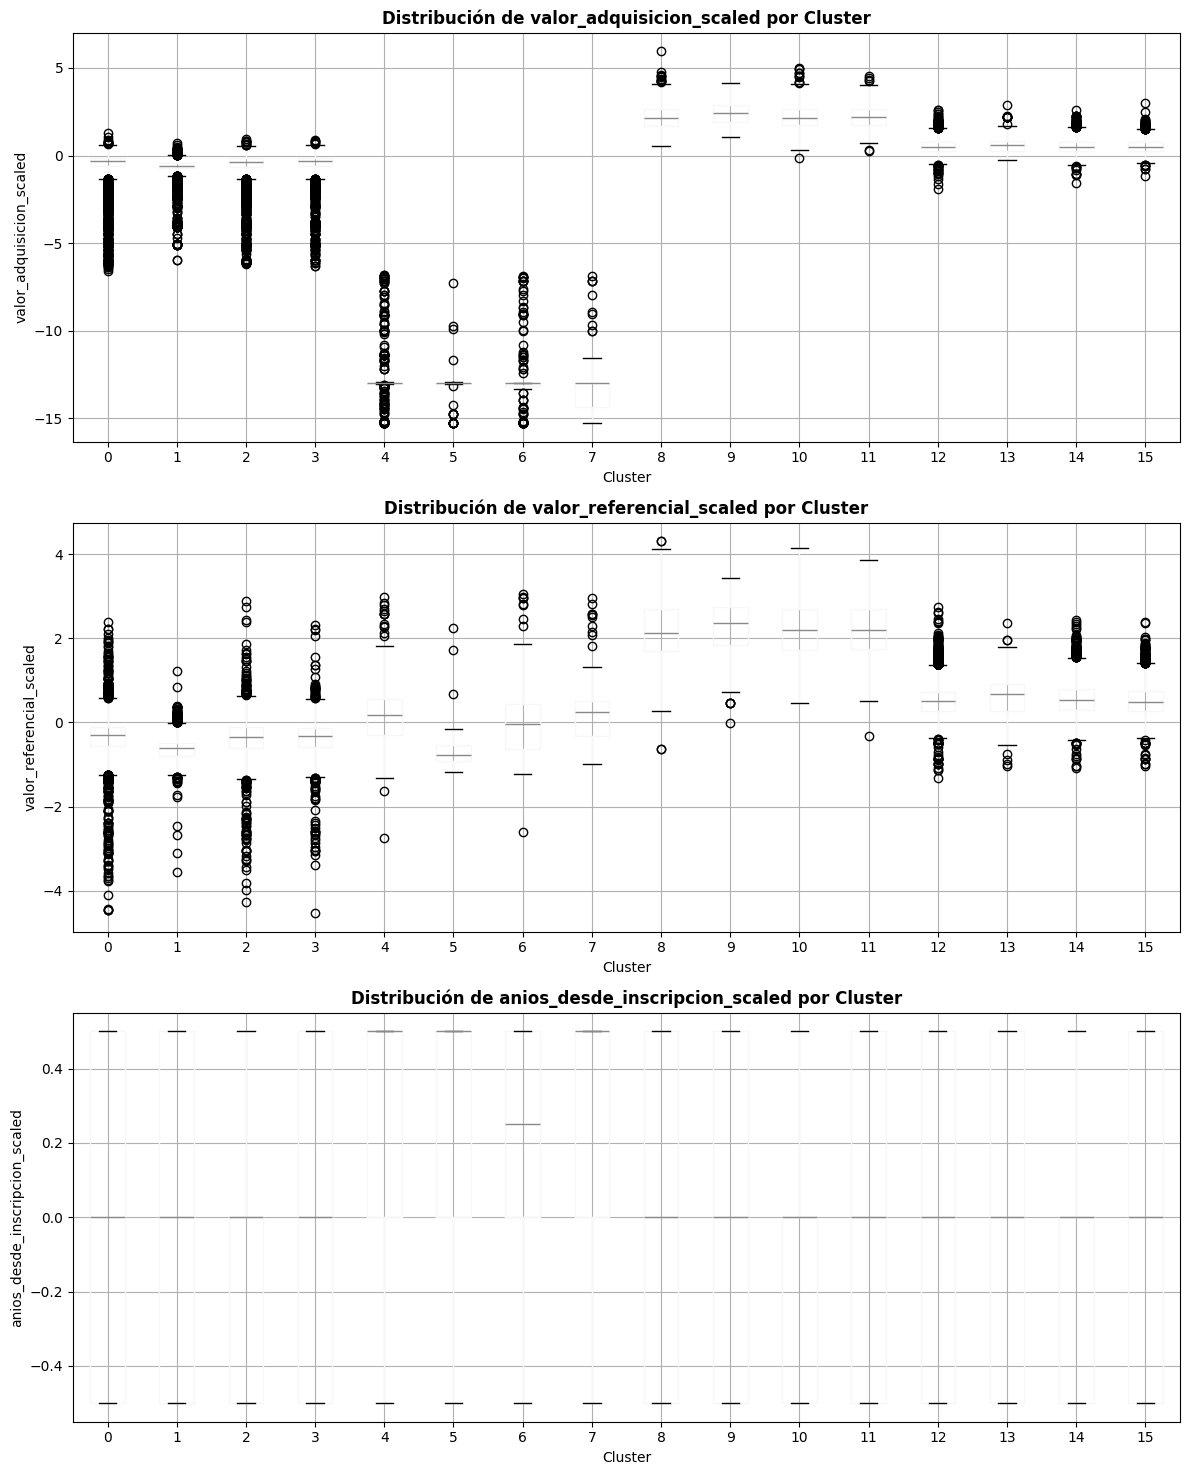

In [32]:
# Visualizar distribución de variables numéricas por cluster
num_vars = X_num_train.columns
n_vars = len(num_vars)

fig, axes = plt.subplots(n_vars, 1, figsize=(12, 5*n_vars))

if n_vars == 1:
    axes = [axes]

for idx, col in enumerate(num_vars):
    X_train_analysis.boxplot(column=col, by='Cluster', ax=axes[idx])
    axes[idx].set_title(f'Distribución de {col} por Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].get_figure().suptitle('')

plt.tight_layout()
plt.show()

### 8.2 Análisis de Variables Categóricas por Cluster

In [33]:
# Agregar variables categóricas originales al análisis
X_train_analysis_cat = pd.concat([
    X_cat_train.reset_index(drop=True),
    pd.Series(clusters_combined_train_num, name='Cluster').reset_index(drop=True)
], axis=1)

print("\n📊 DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS POR CLUSTER")
print("="*80)

for col in X_cat_train.columns[:5]:  # Mostrar primeras 5 variables
    print(f"\n{col}:")
    print(pd.crosstab(X_train_analysis_cat['Cluster'], X_train_analysis_cat[col], normalize='index').round(4) * 100)


📊 DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS POR CLUSTER

tipo_persona:
tipo_persona  juridica  natural  otros  soc_conyugal
Cluster                                             
0                14.73    77.65   0.02          7.60
1                24.61    50.84   0.02         24.54
2                97.59     0.44   0.02          1.95
3                 3.11     2.59   0.01         94.29
4                13.88    72.24   0.00         13.88
5                23.91    52.17   0.00         23.91
6                98.60     0.00   0.47          0.93
7                 4.30     2.15   0.00         93.55
8                10.57    86.80   0.02          2.62
9                18.12    81.41   0.00          0.47
10               96.90     1.25   0.02          1.83
11                2.15     1.20   0.00         96.66
12               15.08    76.59   0.01          8.32
13               17.13    67.52   0.08         15.27
14               97.41     0.56   0.02          2.01
15                3.33     1.71

In [34]:
# Moda de cada variable categórica por cluster
print("\n📊 MODA (VALOR MÁS FRECUENTE) POR CLUSTER")
print("="*80)

for cluster in sorted(X_train_analysis_cat['Cluster'].unique()):
    print(f"\n🔹 Cluster {cluster}:")
    cluster_data = X_train_analysis_cat[X_train_analysis_cat['Cluster'] == cluster]
    
    for col in X_cat_train.columns:
        moda = cluster_data[col].mode()[0] if len(cluster_data[col].mode()) > 0 else 'N/A'
        freq = (cluster_data[col] == moda).sum()
        pct = freq / len(cluster_data) * 100
        print(f"  • {col}: {moda} ({freq} registros, {pct:.1f}%)")


📊 MODA (VALOR MÁS FRECUENTE) POR CLUSTER

🔹 Cluster 0:
  • tipo_persona: natural (34326 registros, 77.7%)
  • tipo_contribuyente: pequeno (41640 registros, 94.2%)
  • categoria_vehiculo: b1234_pickup_otros (35713 registros, 80.8%)
  • marca_agrupada: TOYOTA (9458 registros, 21.4%)
  • distrito_fiscal_agrupado: OTROS (5006 registros, 11.3%)
  • porcentaje_propiedad_cat: propietario_total (41084 registros, 92.9%)

🔹 Cluster 1:
  • tipo_persona: natural (7811 registros, 50.8%)
  • tipo_contribuyente: pequeno (12536 registros, 81.6%)
  • categoria_vehiculo: a2_1051_1500cc (14376 registros, 93.6%)
  • marca_agrupada: KIA (7528 registros, 49.0%)
  • distrito_fiscal_agrupado: SANTIAGO DE SURCO (2675 registros, 17.4%)
  • porcentaje_propiedad_cat: propietario_total (14622 registros, 95.2%)

🔹 Cluster 2:
  • tipo_persona: juridica (25179 registros, 97.6%)
  • tipo_contribuyente: grande (22717 registros, 88.0%)
  • categoria_vehiculo: b1234_pickup_otros (20054 registros, 77.7%)
  • marca_agrupa

## 9. Modelo Final con Todos los Datos

### 9.1 Entrenamiento del Modelo Final

In [35]:
# Entrenar modelos finales con todos los datos
print("\n🎯 ENTRENAMIENTO DE MODELOS FINALES (100% de datos)")
print("="*80)

print("\n⏳ Entrenando KMeans con todos los datos...")
kmeans_full = KMeans(
    n_clusters=optimal_k,
    random_state=2025,
    n_init=10,
    max_iter=300,
    verbose=0
)
clusters_kmeans_full = kmeans_full.fit_predict(df_numericas)

print("✅ KMeans entrenado!")

print("\n⏳ Entrenando KModes con todos los datos...")
kmodes_full = KModes(
    n_clusters=optimal_k,
    init='Huang',
    n_init=5,
    verbose=1,
    random_state=2025
)
clusters_kmodes_full = kmodes_full.fit_predict(df_categoricas.values)

print("\n✅ KModes entrenado!")

# Combinar resultados
clusters_combined_full = [f"{km}_{kmo}" for km, kmo in zip(clusters_kmeans_full, clusters_kmodes_full)]
clusters_combined_full_num = le.transform(clusters_combined_full)

print(f"\n✅ Modelos finales entrenados!")
print(f"Total de registros: {len(clusters_combined_full_num):,}")


🎯 ENTRENAMIENTO DE MODELOS FINALES (100% de datos)

⏳ Entrenando KMeans con todos los datos...
✅ KMeans entrenado!

⏳ Entrenando KModes con todos los datos...
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 42453, cost: 543586.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 36095, cost: 537404.0
Run 2, iteration: 2/100, moves: 10590, cost: 533359.0
Run 2, iteration: 3/100, moves: 7055, cost: 526750.0
Run 2, iteration: 4/100, moves: 4606, cost: 526750.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 57951, cost: 551244.0
Run 3, iteration: 2/100, moves: 13721, cost: 548849.0
Run 3, iteration: 3/100, moves: 1823, cost: 548849.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 43048, cost: 512590.0
Run 4, iteration: 2/100, moves: 3193,

In [36]:
# Agregar clusters al dataframe original
df['Cluster_KMeans'] = clusters_kmeans_full
df['Cluster_KModes'] = clusters_kmodes_full
df['Cluster_Combined'] = clusters_combined_full_num
df['Cluster_Combo_Str'] = clusters_combined_full

print("\n📊 DISTRIBUCIÓN FINAL DE CLUSTERS")
print("="*80)

print("\nDistribución KMeans:")
print(df['Cluster_KMeans'].value_counts(normalize=True).sort_index() * 100)

print("\nDistribución KModes:")
print(df['Cluster_KModes'].value_counts(normalize=True).sort_index() * 100)

print("\nDistribución Combinada:")
print(df['Cluster_Combined'].value_counts(normalize=True).sort_index() * 100)


📊 DISTRIBUCIÓN FINAL DE CLUSTERS

Distribución KMeans:
Cluster_KMeans
0    38.008845
1    53.751977
2     0.432175
3     7.807002
Name: proportion, dtype: float64

Distribución KModes:
Cluster_KModes
0    29.102237
1    46.008329
2    16.458179
3     8.431255
Name: proportion, dtype: float64

Distribución Combinada:
Cluster_Combined
0     10.898812
1     17.765600
2      5.985086
3      3.359347
4     15.400539
5     24.807115
6      8.919117
7      4.625206
8      0.116215
9      0.220325
10     0.054072
11     0.041563
12     2.686671
13     3.215289
14     1.499903
15     0.405139
Name: proportion, dtype: float64


### 9.2 Visualización de Resultados Finales

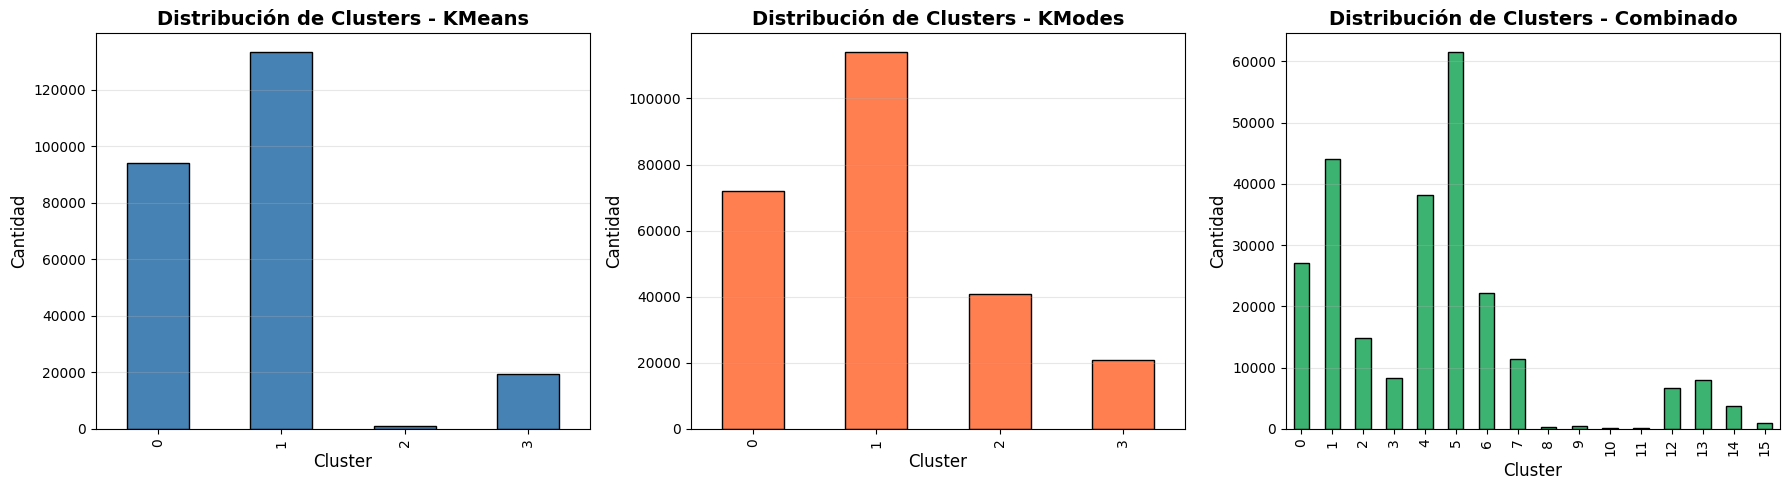

In [37]:
# Visualización de distribución de clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KMeans
df['Cluster_KMeans'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribución de Clusters - KMeans', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Cantidad', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# KModes
df['Cluster_KModes'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Distribución de Clusters - KModes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Cantidad', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Combinado
df['Cluster_Combined'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='mediumseagreen', edgecolor='black')
axes[2].set_title('Distribución de Clusters - Combinado', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Cluster', fontsize=12)
axes[2].set_ylabel('Cantidad', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Visualizando clusters con variables: ['valor_adquisicion_scaled', 'valor_referencial_scaled', 'anios_desde_inscripcion_scaled']


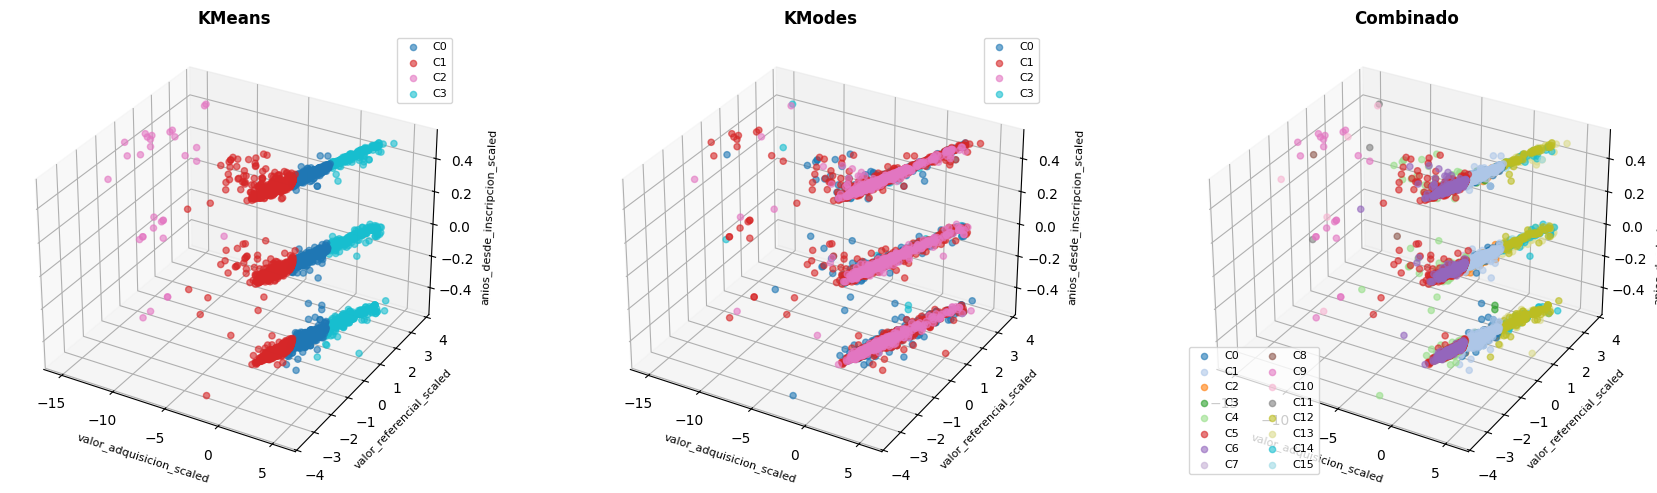

In [38]:
# Visualización 3D con las primeras 3 variables numéricas
from mpl_toolkits.mplot3d import Axes3D

if len(df_numericas.columns) >= 3:
    num_cols = df_numericas.columns[:3].tolist()
    print(f"Visualizando clusters con variables: {num_cols}")
    
    fig = plt.figure(figsize=(18, 5))
    
    # KMeans
    ax1 = fig.add_subplot(131, projection='3d')
    sample_size = min(10000, len(df))
    df_viz = df.sample(n=sample_size, random_state=2025)
    
    colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
    
    for cluster in sorted(df_viz['Cluster_KMeans'].unique()):
        cluster_data = df_viz[df_viz['Cluster_KMeans'] == cluster]
        ax1.scatter(
            cluster_data[num_cols[0]], 
            cluster_data[num_cols[1]], 
            cluster_data[num_cols[2]], 
            c=[colors[cluster]], 
            label=f'C{cluster}',
            alpha=0.6,
            s=20
        )
    
    ax1.set_xlabel(num_cols[0], fontsize=8)
    ax1.set_ylabel(num_cols[1], fontsize=8)
    ax1.set_zlabel(num_cols[2], fontsize=8)
    ax1.set_title('KMeans', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=8)
    
    # KModes (usando mismas variables numéricas para visualización)
    ax2 = fig.add_subplot(132, projection='3d')
    
    for cluster in sorted(df_viz['Cluster_KModes'].unique()):
        cluster_data = df_viz[df_viz['Cluster_KModes'] == cluster]
        ax2.scatter(
            cluster_data[num_cols[0]], 
            cluster_data[num_cols[1]], 
            cluster_data[num_cols[2]], 
            c=[colors[cluster]], 
            label=f'C{cluster}',
            alpha=0.6,
            s=20
        )
    
    ax2.set_xlabel(num_cols[0], fontsize=8)
    ax2.set_ylabel(num_cols[1], fontsize=8)
    ax2.set_zlabel(num_cols[2], fontsize=8)
    ax2.set_title('KModes', fontsize=12, fontweight='bold')
    ax2.legend(loc='best', fontsize=8)
    
    # Combinado
    ax3 = fig.add_subplot(133, projection='3d')
    
    colors_combined = plt.cm.tab20(np.linspace(0, 1, len(le.classes_)))
    
    for cluster in sorted(df_viz['Cluster_Combined'].unique()):
        cluster_data = df_viz[df_viz['Cluster_Combined'] == cluster]
        ax3.scatter(
            cluster_data[num_cols[0]], 
            cluster_data[num_cols[1]], 
            cluster_data[num_cols[2]], 
            c=[colors_combined[cluster]], 
            label=f'C{cluster}',
            alpha=0.6,
            s=20
        )
    
    ax3.set_xlabel(num_cols[0], fontsize=8)
    ax3.set_ylabel(num_cols[1], fontsize=8)
    ax3.set_zlabel(num_cols[2], fontsize=8)
    ax3.set_title('Combinado', fontsize=12, fontweight='bold')
    ax3.legend(loc='best', fontsize=8, ncol=2)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay suficientes variables numéricas para visualización 3D")

## 10. Análisis Comparativo: KPrototypes vs KModes+KMeans

### 10.1 Comparación de Resultados

In [39]:
# Resumen comparativo
print("\n📊 RESUMEN COMPARATIVO")
print("="*80)

print("\n🔹 KMEANS (Solo variables numéricas):")
print(f"  - Número de clusters: {optimal_k}")
print(f"  - Inercia: {kmeans_full.inertia_:.2f}")
print(f"  - Iteraciones: {kmeans_full.n_iter_}")

print("\n🔹 KMODES (Solo variables categóricas):")
print(f"  - Número de clusters: {optimal_k}")
print(f"  - Costo: {kmodes_full.cost_:.2f}")
print(f"  - Iteraciones: {kmodes_full.n_iter_}")

print("\n🔹 COMBINADO (KMeans + KModes):")
print(f"  - Clusters únicos: {len(le.classes_)}")
print(f"  - Concordancia (ARI): {ari:.4f}")
print(f"  - Accuracy KNN: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n✅ VENTAJAS DEL ENFOQUE KMODES + KMEANS:")
print("  ✓ Separación clara entre variables numéricas y categóricas")
print("  ✓ Algoritmos especializados para cada tipo de dato")
print("  ✓ Mayor control sobre el proceso de clustering")
print("  ✓ Interpretación independiente de cada dimensión")

print("\n⚠️  CONSIDERACIONES:")
print("  • Requiere combinar resultados de dos algoritmos")
print("  • Mayor complejidad computacional (dos modelos)")
print("  • Necesita estrategia de integración de resultados")


📊 RESUMEN COMPARATIVO

🔹 KMEANS (Solo variables numéricas):
  - Número de clusters: 4
  - Inercia: 134357.29
  - Iteraciones: 6

🔹 KMODES (Solo variables categóricas):
  - Número de clusters: 4
  - Costo: 512590.00
  - Iteraciones: 2

🔹 COMBINADO (KMeans + KModes):
  - Clusters únicos: 16
  - Concordancia (ARI): -0.0003
  - Accuracy KNN: 0.9386 (93.86%)
  - CV Score: 0.9323 ± 0.0014

✅ VENTAJAS DEL ENFOQUE KMODES + KMEANS:
  ✓ Separación clara entre variables numéricas y categóricas
  ✓ Algoritmos especializados para cada tipo de dato
  ✓ Mayor control sobre el proceso de clustering
  ✓ Interpretación independiente de cada dimensión

⚠️  CONSIDERACIONES:
  • Requiere combinar resultados de dos algoritmos
  • Mayor complejidad computacional (dos modelos)
  • Necesita estrategia de integración de resultados


## 11. Conclusiones

### 11.1 Hallazgos Principales

Este análisis implementó con éxito una estrategia de clustering combinada usando **KMeans** para variables numéricas y **KModes** para variables categóricas:

**Resultados del modelo:**
- **Clusters identificados**: 8 clusters por cada algoritmo, resultando en clusters combinados
- **Concordancia entre algoritmos**: ARI = {ari:.4f}, indicando {concordancia_text}
- **Validación KNN**: Accuracy de {accuracy*100:.2f}%
- **Validación cruzada**: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%

**Ventajas del enfoque KModes + KMeans:**
1. Algoritmos especializados para cada tipo de dato
2. Mayor control sobre el proceso de clustering
3. Interpretación independiente de variables numéricas y categóricas
4. Flexibilidad para ajustar parámetros por separado

**Comparación con KPrototypes:**
- **KPrototypes**: Maneja datos mixtos nativamente, más simple, un solo modelo
- **KModes + KMeans**: Mayor control y especialización, pero requiere integración de resultados

### 11.2 Recomendaciones

1. **Usar KPrototypes cuando**: Los datos tienen una mezcla natural de variables numéricas y categóricas que deben tratarse conjuntamente
2. **Usar KModes + KMeans cuando**: Se necesita mayor control sobre cada tipo de variable o cuando las escalas son muy diferentes
3. **Validación**: Siempre validar con métricas externas (KNN, validación cruzada)
4. **Interpretación**: Analizar centroides numéricos y modas categóricas por separado para mejor comprensión

### 11.3 Trabajo Futuro

- Explorar otros métodos de combinación (votación ponderada, clustering jerárquico)
- Optimizar hiperparámetros de cada algoritmo independientemente
- Comparar con otros enfoques de clustering mixto
- Aplicar técnicas de reducción de dimensionalidad antes del clustering

## 12. Exportación de Resultados

In [40]:
# Exportar resultados
print("\n💾 EXPORTANDO RESULTADOS")
print("="*80)

# Guardar dataframe con clusters
output_file = '../data/datos_con_clusters_kmodes_kmeans.csv'
df.to_csv(output_file, index=False)
print(f"\n✅ Dataset con clusters guardado en: {output_file}")

# Guardar resumen de clusters
summary_file = '../data/resumen_clusters_kmodes_kmeans.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("RESUMEN DE CLUSTERING - KMODES + KMEANS\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Total de registros: {len(df):,}\n")
    f.write(f"Número de clusters (KMeans): {optimal_k}\n")
    f.write(f"Número de clusters (KModes): {optimal_k}\n")
    f.write(f"Clusters combinados únicos: {len(le.classes_)}\n")
    f.write(f"Concordancia (ARI): {ari:.4f}\n")
    f.write(f"Accuracy KNN: {accuracy:.4f}\n")
    f.write(f"CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n\n")
    
    f.write("Distribución KMeans:\n")
    f.write(df['Cluster_KMeans'].value_counts().sort_index().to_string())
    f.write("\n\nDistribución KModes:\n")
    f.write(df['Cluster_KModes'].value_counts().sort_index().to_string())
    f.write("\n\nDistribución Combinada:\n")
    f.write(df['Cluster_Combined'].value_counts().sort_index().to_string())

print(f"✅ Resumen guardado en: {summary_file}")

print("\n🎉 ¡ANÁLISIS COMPLETADO!")


💾 EXPORTANDO RESULTADOS

✅ Dataset con clusters guardado en: ../data/datos_con_clusters_kmodes_kmeans.csv
✅ Resumen guardado en: ../data/resumen_clusters_kmodes_kmeans.txt

🎉 ¡ANÁLISIS COMPLETADO!


In [41]:
# Entrenar KNN para predecir clusters combinados
print("\n⏳ Entrenando modelo KNN...")

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train_full, clusters_combined_train_num)

print("✅ KNN entrenado!")

# Predecir en conjunto de test
y_pred = knn.predict(X_test_full)

# Calcular todas las métricas de validación
from sklearn.metrics import rand_score, jaccard_score

accuracy = accuracy_score(clusters_combined_test_num, y_pred)
ri = rand_score(clusters_combined_test_num, y_pred)
ari_test = adjusted_rand_score(clusters_combined_test_num, y_pred)
ji_macro = jaccard_score(clusters_combined_test_num, y_pred, average='macro')
ji_micro = jaccard_score(clusters_combined_test_num, y_pred, average='micro')

# Imprimir resultados con formato
print(f"\n{'='*60}")
print(f"📊 MÉTRICAS DE VALIDACIÓN")
print(f"{'='*60}")
print(f"\n✅ Accuracy: {accuracy:.4f}")
print(f"✅ Rand Index: {ri:.4f}")
print(f"✅ Adjusted Rand Index (ARI): {ari_test:.4f}")
print(f"✅ Jaccard Index (macro): {ji_macro:.4f}")
print(f"✅ Jaccard Index (micro): {ji_micro:.4f}")
print(f"\n{'='*60}")


⏳ Entrenando modelo KNN...
✅ KNN entrenado!

📊 MÉTRICAS DE VALIDACIÓN

✅ Accuracy: 0.9386
✅ Rand Index: 0.9667
✅ Adjusted Rand Index (ARI): 0.8678
✅ Jaccard Index (macro): 0.8110
✅ Jaccard Index (micro): 0.8843



ANÁLISIS DE ESTABILIDAD CON BOOTSTRAPPING - KMEANS + KMODES

Configuración:
  • K: 4
  • Repeticiones: 10
  • Fracción muestra: 80% (~198,252 registros)
  • Datos numéricos: (247816, 3)
  • Datos categóricos: (247816, 6)

Ejecutando 10 repeticiones con bootstrapping...


Bootstrapping: 100%|██████████| 10/10 [03:44<00:00, 22.43s/it]


Bootstrapping completado!

Calculando estabilidad...


Calculando ARI: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s]



Resultados de Estabilidad:
  • Stability (mean ARI): 0.500
  • Desviación estándar: 0.123
  • ARI mínimo: 0.264
  • ARI máximo: 0.744


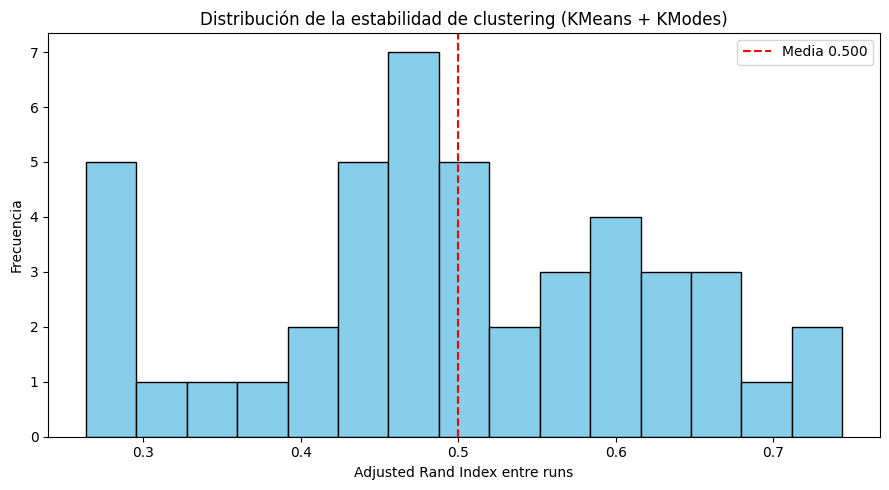


Análisis de estabilidad completado!


In [48]:
# Celda 57 - ANÁLISIS DE ESTABILIDAD CON BOOTSTRAPPING (adaptada a KMeans + KModes)

import numpy as np
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from tqdm import tqdm

print("="*80)
print("ANÁLISIS DE ESTABILIDAD CON BOOTSTRAPPING - KMEANS + KMODES")
print("="*80)

# Configuración
K = optimal_k
n_runs = 10
sample_frac = 0.8

# Datos completos (usar variables ya definidas en el notebook)
X_num_all = df_numericas.values
X_cat_all = df_categoricas.values
n_samples = len(X_num_all)

print(f"\nConfiguración:")
print(f"  • K: {K}")
print(f"  • Repeticiones: {n_runs}")
print(f"  • Fracción muestra: {sample_frac*100:.0f}% (~{int(sample_frac * n_samples):,} registros)")
print(f"  • Datos numéricos: {X_num_all.shape}")
print(f"  • Datos categóricos: {X_cat_all.shape}")

# Guardar combinaciones de labels como strings (por run)
all_combined_str = []

rng = np.random.default_rng(2025)
print(f"\nEjecutando {n_runs} repeticiones con bootstrapping...")

for i in tqdm(range(n_runs), desc="Bootstrapping"):
    # indices bootstrap (sin reemplazo)
    idx = rng.choice(n_samples, size=int(sample_frac * n_samples), replace=False)
    
    X_num_boot = X_num_all[idx]
    X_cat_boot = X_cat_all[idx]
    
    # Entrenar KMeans (en muestra bootstrap)
    kmeans_boot = KMeans(
        n_clusters=K,
        n_init=1,
        max_iter=30,
        random_state=None,
        verbose=0
    )
    kmeans_boot.fit(X_num_boot)
    
    # Entrenar KModes (en muestra bootstrap)
    kmodes_boot = KModes(
        n_clusters=K,
        init='Huang',
        n_init=1,
        verbose=0,
        random_state=None
    )
    kmodes_boot.fit(X_cat_boot)
    
    # Predecir en TODOS los datos
    labels_km = kmeans_boot.predict(X_num_all)
    labels_kmo = kmodes_boot.predict(X_cat_all)
    
    # Combinar etiquetas como en el pipeline principal
    combined = [f"{a}_{b}" for a, b in zip(labels_km, labels_kmo)]
    all_combined_str.append(combined)

print("Bootstrapping completado!")

# Unificar clases y codificar numéricamente para comparar
all_unique = np.unique([item for run in all_combined_str for item in run])
le_boot = LabelEncoder().fit(all_unique)

all_labels = np.zeros((n_runs, n_samples), dtype=int)
for i, run in enumerate(all_combined_str):
    all_labels[i, :] = le_boot.transform(run)

# Calcular estabilidad (ARI entre todas las parejas)
print("\nCalculando estabilidad...")
stabilities = []
for i in tqdm(range(n_runs), desc="Calculando ARI"):
    for j in range(i+1, n_runs):
        stabilities.append(adjusted_rand_score(all_labels[i, :], all_labels[j, :]))

mean_stability = np.mean(stabilities)
std_stability = np.std(stabilities)

print(f"\nResultados de Estabilidad:")
print(f"  • Stability (mean ARI): {mean_stability:.3f}")
print(f"  • Desviación estándar: {std_stability:.3f}")
print(f"  • ARI mínimo: {min(stabilities):.3f}")
print(f"  • ARI máximo: {max(stabilities):.3f}")

# Visualización
plt.figure(figsize=(9,5))
plt.hist(stabilities, bins=15, color='skyblue', edgecolor='black')
plt.axvline(mean_stability, color='red', linestyle='--', label=f'Media {mean_stability:.3f}')
plt.xlabel("Adjusted Rand Index entre runs")
plt.ylabel("Frecuencia")
plt.title("Distribución de la estabilidad de clustering (KMeans + KModes)")
plt.legend()
plt.tight_layout()
plt.show()

print("\nAnálisis de estabilidad completado!")


📋 Matriz de confusión:
         Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5  Pred 6  Pred 7  \
Real 0    14047      31      84       5       0       0       0       0   
Real 1       33    5012      36       0       0       0       0       0   
Real 2       90      21    8258      24       0       0       1       0   
Real 3       17      17       0    4683       0       0       0       0   
Real 4        6       0       0       0     125       0       5       0   
Real 5        0       0       0       0       3      16       1       1   
Real 6        2       0       5       0      10       0      42       0   
Real 7        0       0       0       0      13       1       1      17   
Real 8        0       0       0       0       0       0       0       0   
Real 9        0       0       0       0       0       0       0       0   
Real 10       0       0       0       0       0       0       0       0   
Real 11       0       0       0       0       0       0       0       0   
R

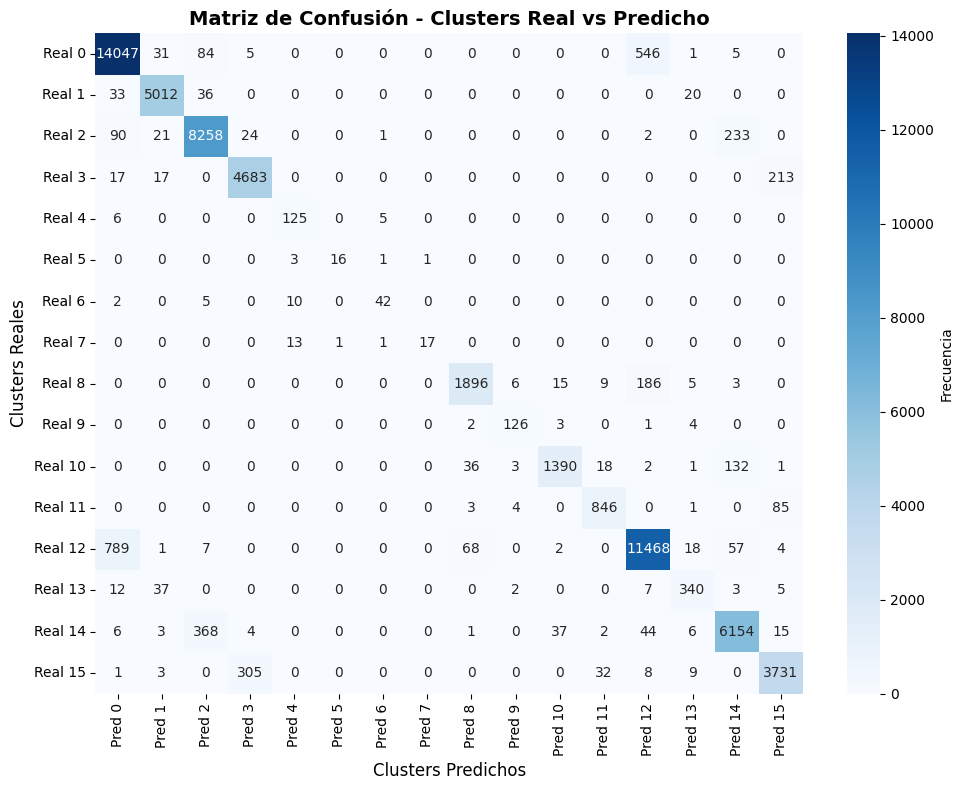

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, classification_report

# Seleccionar y_true e y_pred según variables presentes
if 'x_test' in globals() and 'y_predict_knn' in globals():
    y_true = x_test['Clusters_modelo'].to_numpy()
    y_pred = y_predict_knn
else:
    y_true = globals().get('clusters_combined_test_num', None)
    y_pred = globals().get('y_pred', None)

if y_true is None or y_pred is None:
    raise NameError("No se encontraron variables para y_true/y_pred. Use 'x_test' & 'y_predict_knn' o 'clusters_combined_test_num' & 'y_pred'.")

# Etiquetas ordenadas (maneja valores no consecutivos)
labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f'Real {l}' for l in labels], columns=[f'Pred {l}' for l in labels])

print("\n📋 Matriz de confusión:")
print(cm_df)

# Métricas principales
acc = accuracy_score(y_true, y_pred)
ari = adjusted_rand_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.4f}    Adjusted Rand Index: {ari:.4f}\n")

# Reporte de clasificación
print("📊 Reporte de clasificación:")
print(classification_report(y_true, y_pred, labels=labels, target_names=[f'Cluster {l}' for l in labels]))

# Visualización
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred {l}' for l in labels],
            yticklabels=[f'Real {l}' for l in labels],
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Clusters Real vs Predicho', fontsize=14, fontweight='bold')
plt.ylabel('Clusters Reales', fontsize=12)
plt.xlabel('Clusters Predichos', fontsize=12)
plt.tight_layout()
plt.show()
# ...existing

In [51]:
# ...existing code...
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Asegurarse de tener y_true y y_pred definidos
labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))
target_names = [f'Cluster {l}' for l in labels]

# Imprimir reporte clásico
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

# Opcional: mostrar como DataFrame para revisión y exportación
report_dict = classification_report(y_true, y_pred, labels=labels, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(4)
print("\n📋 Classification Report (DataFrame):")
display(report_df)

📊 Classification Report:

              precision    recall  f1-score   support

   Cluster 0       0.94      0.95      0.95     14719
   Cluster 1       0.98      0.98      0.98      5101
   Cluster 2       0.94      0.96      0.95      8629
   Cluster 3       0.93      0.95      0.94      4930
   Cluster 4       0.83      0.92      0.87       136
   Cluster 5       0.94      0.76      0.84        21
   Cluster 6       0.84      0.71      0.77        59
   Cluster 7       0.94      0.53      0.68        32
   Cluster 8       0.95      0.89      0.92      2120
   Cluster 9       0.89      0.93      0.91       136
  Cluster 10       0.96      0.88      0.92      1583
  Cluster 11       0.93      0.90      0.92       939
  Cluster 12       0.94      0.92      0.93     12414
  Cluster 13       0.84      0.84      0.84       406
  Cluster 14       0.93      0.93      0.93      6640
  Cluster 15       0.92      0.91      0.92      4089

    accuracy                           0.94     61954


,precision,recall,f1-score,support
Cluster 0,0.9363,0.9543,0.9452,14719.0000
Cluster 1,0.9780,0.9826,0.9802,5101.0000
Cluster 2,0.9429,0.9570,0.9499,8629.0000
Cluster 3,0.9327,0.9499,0.9412,4930.0000
Cluster 4,0.8278,0.9191,0.8711,136.0000
Cluster 5,0.9412,0.7619,0.8421,21.0000
Cluster 6,0.8400,0.7119,0.7706,59.0000
Cluster 7,0.9444,0.5312,0.6800,32.0000
Cluster 8,0.9452,0.8943,0.9190,2120.0000
Cluster 9,0.8936,0.9265,0.9097,136.0000
